<a href="https://colab.research.google.com/github/dnbaohan/graduation_thesis/blob/Hybrid-Fourier-Domain-and-Deep-Learning-Approaches-for-Financial-Market-Forecasting-and-Pattern-Recognition/Graduation_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Setup

In [ ]:
!pip install yfinance --quiet
!pip install scikit-learn --quiet
!pip install scikeras --quiet

In [ ]:
# ---- Core Utilities ----
import os
import math
import warnings
from datetime import datetime, timedelta
from calendar import monthrange
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(0)
plt.rcParams["figure.figsize"] = (15, 8)

# =========================================================
# ⚙️ Machine Learning / Statistics
# =========================================================
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from statsmodels.tsa.arima.model import ARIMA

# =========================================================
# 📉 Deep Learning (Keras / TensorFlow)
# =========================================================
HAS_TF = False
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, regularizers
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (
        Input, Dense, Dropout, LSTM, Concatenate, BatchNormalization, Conv1D, MaxPooling1D, Flatten
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.losses import Huber
    from tensorflow.keras.callbacks import EarlyStopping

    HAS_TF = True
except Exception as e:
    print("TensorFlow not available:", e)

# =========================================================
# 🤖 SciKeras Wrapper
# =========================================================
HAS_SCIKERAS = False
try:
    from scikeras.wrappers import KerasRegressor
    HAS_SCIKERAS = True
except Exception as e:
    print("SciKeras not available:", e)

# =========================================================
# 📊 Technical Indicators (TA-Lib)
# =========================================================
try:
    import talib
except:
    !pip install TA-Lib --quiet
    import talib

# =========================================================
# 🔊 Frequency-Domain / Signal Processing
# =========================================================
from scipy.fft import fft, ifft, rfft, irfft, rfftfreq, fftfreq
from scipy.signal import stft, get_window, detrend

# =========================================================
# 🌊 Wavelet Transform
# =========================================================
HAS_PYWT = False
try:
    import pywt
    HAS_PYWT = True
except Exception:
    pass

# =========================================================
# 💹 Financial Data
# =========================================================
import yfinance as yf

# =========================================================
# 🗂 Folder Creation
# =========================================================
os.makedirs("results/models", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)

# =========================================================
# 🧠 Custom Keras Wrapper (for GridSearchCV)
# =========================================================
class KerasRegWrapper(BaseEstimator, RegressorMixin):
    """
    A SciKit-Learn compatible wrapper for Keras models.
    Allows tuning via GridSearchCV.
    """
    def __init__(self, optimizer='adam', dropout_rate=0.2, units=64, batch_size=32, epochs=30):
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.units = units
        self.batch_size = batch_size
        self.epochs = epochs
        self.model_ = None

    def build_model(self):
        model = Sequential()
        model.add(Dense(self.units, activation='relu'))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=self.optimizer, loss='mse')
        return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 32.0 MB/s eta 0:00:00


# Data Preparation

In [ ]:
TICKER = 'AMZN'
start_date = '2020-01-01'
end_date = '2025-01-01'
data = yf.download(TICKER, start=start_date, end=end_date)
data = data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 1258 number of days in the dataset.


## Ultilities Data

In [ ]:
def clean_yfinance_multiindex(data: pd.DataFrame) -> pd.DataFrame:
    """Clean yfinance multi-index columns (remove ticker row like 'AMZN') and flatten."""
    # If the input is empty, return it immediately (avoids IndexError on data.iloc[0])
    if data is None or data.shape[0] == 0:
        print("clean_yfinance_multiindex: received empty DataFrame. Returning empty DataFrame.")
        return data

    # If columns are MultiIndex -> flatten to a single level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[0] if col[0] != "" else col[1] for col in data.columns]

    # If the first row contains ticker symbols (e.g., AMZN, AMZN, ...)
    try:
        if data.iloc[0].astype(str).str.fullmatch(r"[A-Z]+").any():
            data = data.iloc[1:].reset_index(drop=True)
    except IndexError:
        # Defensive: if indexing fails for any reason, return empty DataFrame
        print("clean_yfinance_multiindex: indexing failed while checking header row — returning empty DataFrame.")
        return pd.DataFrame()

    # Standardize column names
    rename_map = {
        "Date": "Date",
        "Close": "Close",
        "High": "High",
        "Low": "Low",
        "Open": "Open",
        "Volume": "Volume"
    }
    data = data.rename(columns=rename_map)

    # Convert Date column to datetime
    if "Date" in data.columns:
        data["Date"] = pd.to_datetime(data["Date"])

    # Convert numeric columns to float/int
    num_cols = ["Close", "High", "Low", "Open", "Volume"]
    for c in num_cols:
        if c in data.columns:
            data[c] = pd.to_numeric(data[c], errors="coerce")

    # Drop NaN values if any
    if "Date" in data.columns and "Close" in data.columns:
        data = data.dropna(subset=["Date", "Close"])

    # Sort by Date and reset index
    if "Date" in data.columns:
        data = data.sort_values("Date").reset_index(drop=True)

    return data
data = clean_yfinance_multiindex(data)

## Stock Data Trend

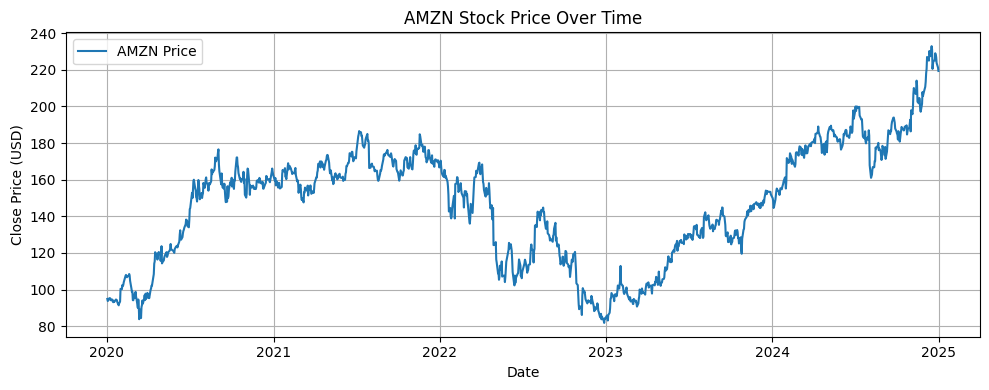

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(data["Date"], data["Close"], label=f"{TICKER} Price")
plt.title(f"{TICKER} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Log Returns and Percentage Change

In [ ]:
# Calculate Log Returns
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
# Calculate % Change
data['Pct_Change'] = data['Close'].pct_change()
data = data.dropna().reset_index(drop=True)

In [ ]:
data

,Date,Close,High,Low,Open,Volume,Log_Return,Pct_Change
0,2020-01-03,93.748497,94.309998,93.224998,93.224998,75288000,-0.012213,-0.012139
1,2020-01-06,95.143997,95.184502,93.000000,93.000000,81236000,0.014776,0.014886
2,2020-01-07,95.343002,95.694504,94.601997,95.224998,80898000,0.002089,0.002092
3,2020-01-08,94.598503,95.550003,94.321999,94.902000,70160000,-0.007839,-0.007809
4,2020-01-09,95.052498,95.890999,94.790001,95.494499,63346000,0.004788,0.004799
...,...,...,...,...,...,...,...,...
1252,2024-12-24,229.050003,229.139999,226.130005,226.940002,15007500,0.017573,0.017729
1253,2024-12-26,227.050003,228.500000,226.669998,228.500000,16146700,-0.008770,-0.008732
1254,2024-12-27,223.750000,226.029999,220.899994,225.600006,27367100,-0.014641,-0.014534
1255,2024-12-30,221.300003,223.000000,218.429993,220.059998,28321200,-0.011010,-0.010950


# LSTM

=== Evaluation Metrics ===
MSE      : 0.000310
RMSE     : 0.017598
MAE      : 0.013250
R²       : -0.018949
Directional Accuracy: 0.6355
Hit Ratio (correct up/down sign): 0.4884
Precision : 0.5137
Recall    : 0.6579
F1-Score  : 0.5769
AUC-ROC   : 0.4775
AUC-PR    : 0.5194

Confusion Matrix (0=Decrease, 1=Increase):
[[30 71]
 [39 75]]

Classification Report (sign):
              precision    recall  f1-score   support

        Giảm     0.4348    0.2970    0.3529       101
        Tăng     0.5137    0.6579    0.5769       114

    accuracy                         0.4884       215
   macro avg     0.4742    0.4775    0.4649       215
weighted avg     0.4766    0.4884    0.4717       215



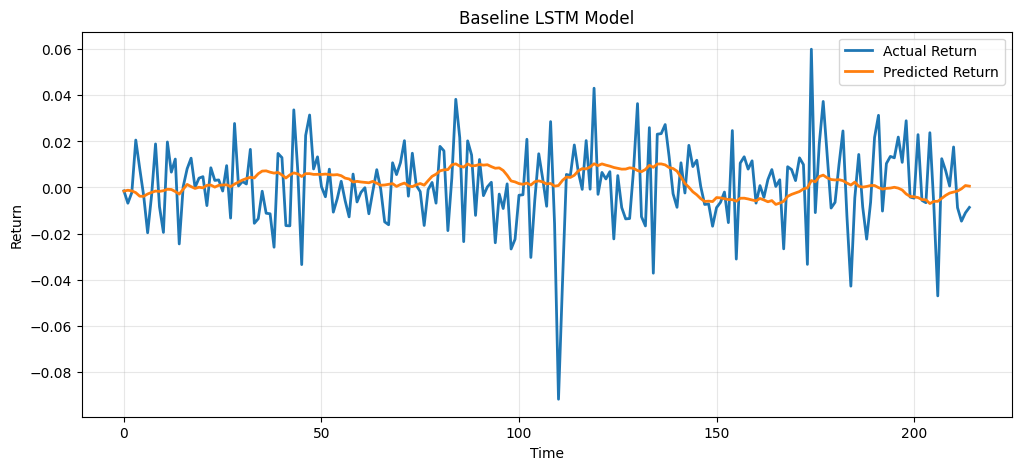

In [ ]:
# ---------------------------
# Feature Engineering (Baseline LSTM)
# ---------------------------
def lstm_features_baseline(df):
    df = df.copy()
    df["Return"] = df["Log_Return"]
    # Additional technical indicators (e.g., MACD, RSI, Bollinger Bands)
    df["RSI"] = talib.RSI(df["Return"].values, timeperiod=14)
    df["MACD"], df["MACD_signal"], _ = talib.MACD(df["Return"].values, fastperiod=12, slowperiod=26, signalperiod=9)
    df["BB_upper"], df["BB_middle"], df["BB_lower"] = talib.BBANDS(df["Return"].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df["EMA_12"] = df["Return"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Return"].ewm(span=26, adjust=False).mean()
    df["MA_5"] = df["Return"].rolling(5).mean()
    df["Vol_5"] = df["Return"].rolling(5).std()
    df["Vol_10"] = df["Return"].rolling(10).std()
    df = df.dropna()  # Drop NaN values
    return df

# ---------------------------
# Create sequences (no change)
# ---------------------------
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# ---------------------------
# LSTM Model (Baseline)
# ---------------------------
from tensorflow.keras.layers import LSTM, Bidirectional, Attention, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_baseline_model(n_features, seq_len):
    inputs = Input(shape=(seq_len, n_features))

    # Sử dụng Bidirectional LSTM để học từ cả quá khứ và tương lai
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    dropout_1 = Dropout(0.3)(lstm_1)

    # Thêm một lớp Bidirectional LSTM khác
    lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(dropout_1)
    dropout_2 = Dropout(0.3)(lstm_2)

    # Áp dụng Attention Mechanism để giúp mô hình chú ý vào các phần quan trọng
    attention = Attention()([lstm_2, lstm_2])  # Attention layer

    # Lớp LSTM cuối cùng để nắm bắt các phụ thuộc dài hạn
    lstm_3 = LSTM(32)(attention)
    dropout_3 = Dropout(0.3)(lstm_3)

    # Đầu ra của mô hình
    output = Dense(1)(dropout_3)

    # Tạo và biên dịch mô hình
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model
# ---------------------------
# Train Baseline Model
# ---------------------------
SEQ_LEN = 30  # Sequence length

# Apply baseline features
df_baseline = lstm_features_baseline(data)

# Define features for the baseline model (no FFT/Wavelet features)
features_baseline = [
    "Return", "EMA_12", "EMA_26", "Vol_5", "Vol_10",
    "MACD", "RSI", "BB_upper", "BB_lower"
]

X_baseline = df_baseline[features_baseline].values
y_baseline = df_baseline["Return"].values

split = int(len(X_baseline) * 0.8)  # 80% for training, 20% for testing
X_train_baseline, X_test_baseline = X_baseline[:split], X_baseline[split:]
y_train_baseline, y_test_baseline = y_baseline[:split], y_baseline[split:]

# Normalize the data
scaler = StandardScaler()
X_train_scaled_baseline = scaler.fit_transform(X_train_baseline)
X_test_scaled_baseline = scaler.transform(X_test_baseline)

X_train_seq_baseline, y_train_seq_baseline = create_sequences(X_train_scaled_baseline, y_train_baseline, SEQ_LEN)
X_test_seq_baseline, y_test_seq_baseline = create_sequences(X_test_scaled_baseline, y_test_baseline, SEQ_LEN)

n_features_baseline = X_train_seq_baseline.shape[2]
baseline_model = build_baseline_model(n_features_baseline, SEQ_LEN)

# Early stopping callback
early_stopping_baseline = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the baseline model
baseline_history = baseline_model.fit(
    X_train_seq_baseline,
    y_train_seq_baseline,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_baseline],
    verbose=0
)

# ---------------------------
# 7. Evaluation Metrics
# ---------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

def evaluate_baseline_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq, plot=True):
    # Dự đoán
    y_pred_train = model.predict(X_train_seq, verbose=0).squeeze()
    y_pred_test  = model.predict(X_test_seq, verbose=0).squeeze()

    # --- Metrics cho Test ---
    mse  = mean_squared_error(y_test_seq, y_pred_test)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_seq, y_pred_test)
    r2   = r2_score(y_test_seq, y_pred_test)

    # Directional Accuracy (dự đoán đúng chiều tăng/giảm)
    actual_dir = np.sign(y_test_seq[1:] - y_test_seq[:-1])   # chiều biến động thực
    pred_dir   = np.sign(y_pred_test[1:]  - y_pred_test[:-1]) # chiều biến động dự đoán
    dir_acc = (actual_dir == pred_dir).mean() if len(actual_dir) > 0 else np.nan

    # Hit Ratio theo dấu (>=0 tăng, <0 giảm)
    actual_sign = (y_test_seq >= 0).astype(int)
    pred_sign   = (y_pred_test >= 0).astype(int)
    hit_ratio   = (actual_sign == pred_sign).mean()

    # Precision, Recall, F1-Score cho phân loại tăng/giảm
    precision = precision_score(actual_sign, pred_sign)
    recall = recall_score(actual_sign, pred_sign)
    f1 = f1_score(actual_sign, pred_sign)

    # AUC-ROC và AUC-PR
    auc_roc = roc_auc_score(actual_sign, pred_sign)
    auc_pr = average_precision_score(actual_sign, pred_sign)

    # Ma trận nhầm lẫn & báo cáo phân loại dấu tăng/giảm
    cm = confusion_matrix(actual_sign, pred_sign, labels=[0, 1])  # 0: giảm, 1: tăng
    cls_report = classification_report(actual_sign, pred_sign, target_names=["Giảm", "Tăng"], digits=4)

    # In kết quả
    print("=== Evaluation Metrics ===")
    print(f"MSE      : {mse:,.6f}")
    print(f"RMSE     : {rmse:,.6f}")
    print(f"MAE      : {mae:,.6f}")
    print(f"R²       : {r2:,.6f}")
    print(f"Directional Accuracy: {dir_acc:.4f}")
    print(f"Hit Ratio (correct up/down sign): {hit_ratio:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"AUC-ROC   : {auc_roc:.4f}")
    print(f"AUC-PR    : {auc_pr:.4f}")

    print("\nConfusion Matrix (0=Decrease, 1=Increase):")
    print(cm)
    print("\nClassification Report (sign):")
    print(cls_report)

    # --- Plots ---
    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(y_test_seq, label="Actual Return", linewidth=2)
        plt.plot(y_pred_test, label="Predicted Return", linewidth=2)
        plt.title("Baseline LSTM Model")
        plt.xlabel("Time")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    # Trả về dictionary nếu bạn muốn log/so sánh
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "directional_accuracy": dir_acc,
        "hit_ratio": hit_ratio,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc_roc": auc_roc,
        "auc_pr": auc_pr,
        "confusion_matrix": cm,
        "classification_report": cls_report,
    }


evaluation_metrics_baseline = evaluate_baseline_model(baseline_model, X_train_seq_baseline, y_train_seq_baseline, X_test_seq_baseline, y_test_seq_baseline)


# Hybrid FFT+LSTM

## FFT

In [ ]:
def fft_smooth(series, keep=20):
    f = np.fft.fft(series)
    f[keep:-keep] = 0
    smoothed = np.real(np.fft.ifft(f))
    return smoothed

## Wavelet Transform

In [ ]:
def wavelet_transform(series, wavelet='db1', level=3):
    coeffs = pywt.wavedec(series, wavelet, level=level)
    # Keep only the approximation coefficients and set detail coefficients to zero for smoothing
    smoothed_coeffs = [coeffs[0]] + [np.zeros_like(d) for d in coeffs[1:]]
    smoothed_series = pywt.waverec(smoothed_coeffs, wavelet)
    # Ensure length matches original series, handle potential size differences due to waverec
    if len(smoothed_series) > len(series):
        smoothed_series = smoothed_series[:len(series)]
    elif len(smoothed_series) < len(series):
        padding_needed = len(series) - len(smoothed_series)
        smoothed_series = np.pad(smoothed_series, (0, padding_needed), mode='edge')
    return smoothed_series

## Feature Engineering ( adding FFT & WT )

In [ ]:
def build_features(df, fft_window_sizes=[10, 20, 40], wavelet='db1', level=3):
    df = df.copy()
    df["Return"] = df["Log_Return"]

    # Ensure necessary columns are float64 for TA-Lib
    for col in ["Close", "High", "Low", "Volume", "Return"]:
        if col in df.columns:
            df[col] = df[col].astype(np.float64)

    # FFT features
    for fft_window in fft_window_sizes:
        df[f"Return_Smooth_{fft_window}"] = fft_smooth(df["Return"].values, keep=fft_window)
        fft_values = np.fft.fft(df["Return"].values)
        fft_abs = np.abs(fft_values)
        df[f"FFT_Amplitude_{fft_window}"] = fft_abs
        df[f"FFT_Phase_{fft_window}"] = np.angle(fft_values)
        df[f"Low_Energy_{fft_window}"] = np.sum(fft_abs[:fft_window])
        df[f"High_Energy_{fft_window}"] = np.sum(fft_abs[fft_window:])

    # Wavelet features: Applying the modified wavelet_transform to the entire 'Return' series
    df['Wavelet_Smooth'] = wavelet_transform(df['Return'].values, wavelet=wavelet, level=level)

    # Additional technical indicators
    df["RSI_14"] = talib.RSI(df["Return"].values, timeperiod=14)
    df["RSI_28"] = talib.RSI(df["Return"].values, timeperiod=28)  # Adding RSI for 28 days
    df["MACD"], df["MACD_signal"], _ = talib.MACD(df["Return"].values, fastperiod=12, slowperiod=26, signalperiod=9)
    df["MACD_5"], df["MACD_signal_5"], _ = talib.MACD(df["Return"].values, fastperiod=5, slowperiod=10, signalperiod=5)
    df["MACD_20"], df["MACD_signal_20"], _ = talib.MACD(df["Return"].values, fastperiod=20, slowperiod=40, signalperiod=9)
    df["BB_upper"], df["BB_middle"], df["BB_lower"] = talib.BBANDS(df["Return"].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df["EMA_12"] = df["Return"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Return"].ewm(span=26, adjust=False).mean()
    df["MA_5"] = df["Return"].rolling(5).mean()
    df["Vol_5"] = df["Return"].rolling(5).std()
    df["Vol_10"] = df["Return"].rolling(10).std()

    # Add On-Balance Volume (OBV)
    df["OBV"] = talib.OBV(df["Close"].values, df["Volume"].values)

    # Add Average True Range (ATR)
    df["ATR_14"] = talib.ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=14)

    df = df.dropna()  # Drop NaN values
    return df


## Create Sequences

In [ ]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

## Hybrid FFT+LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Attention, Dense, Dropout, Input
from tensorflow.keras.models import Model

def build_model(n_features, seq_len):
    inputs = Input(shape=(seq_len, n_features))

    # Sử dụng Bidirectional LSTM để học từ cả quá khứ và tương lai
    lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    dropout_1 = Dropout(0.3)(lstm_1)

    # Thêm một lớp Bidirectional LSTM khác
    lstm_2 = Bidirectional(LSTM(64, return_sequences=True))(dropout_1)
    dropout_2 = Dropout(0.3)(lstm_2)

    # Áp dụng Attention Mechanism để giúp mô hình chú ý vào các phần quan trọng
    attention = Attention()([lstm_2, lstm_2])  # Attention layer

    # Lớp LSTM cuối cùng để nắm bắt các phụ thuộc dài hạn
    lstm_3 = LSTM(32)(attention)
    dropout_3 = Dropout(0.3)(lstm_3)

    # Đầu ra của mô hình
    output = Dense(1)(dropout_3)

    # Tạo và biên dịch mô hình
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model


In [ ]:
# def build_model(n_features, seq_len):
#     model = Sequential([
#         LSTM(128, return_sequences=True, input_shape=(seq_len, n_features)),  # Tăng số neuron và thêm lớp LSTM
#         Dropout(0.3),
#         LSTM(64, return_sequences=True),
#         Dropout(0.3),
#         LSTM(32),
#         Dropout(0.3),
#         Dense(16, activation='relu'),
#         Dense(1)
#     ])
#     model.compile(optimizer="adam", loss="mse")
#     return model

## Train Model

In [ ]:
SEQ_LEN = 30  # Kích thước chuỗi

# Áp dụng các đặc trưng từ FFT vào dữ liệu
fft_window_sizes = [10, 20, 40]  # Các cửa sổ FFT khác nhau
df = build_features(data, fft_window_sizes)
features = [
    "Return", "EMA_12", "EMA_26", "Vol_5", "Vol_10",
    "MACD", "RSI_14", "RSI_28", "BB_upper", "BB_lower", "OBV", "ATR_14",
    "Wavelet_Smooth","MACD_5", "MACD_signal_5", "MACD_20", "MACD_signal_20"
] + [f"Return_Smooth_{fft_window}" for fft_window in fft_window_sizes] + \
    [f"FFT_Amplitude_{fft_window}" for fft_window in fft_window_sizes] + \
    [f"FFT_Phase_{fft_window}" for fft_window in fft_window_sizes] + \
    [f"Low_Energy_{fft_window}" for fft_window in fft_window_sizes] + \
    [f"High_Energy_{fft_window}" for fft_window in fft_window_sizes]

X = df[features].values
y = df["Return"].values

split = int(len(X) * 0.8)  # 80% cho training, 20% cho testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Chuẩn hóa dữ liệu
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LEN)

In [ ]:
n_features = X_train_seq.shape[2]
model = build_model(n_features, SEQ_LEN)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.2,          # Reduce learning rate by a factor of 0.2
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when learning rate is reduced
)

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Save the best model as 'best_model.h5'
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Only save the model if it improves
    mode='min',           # Minimize the validation loss
    verbose=1             # Print a message when model is saved
)

# Train the model with the defined callbacks
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=100,           # Number of epochs
    batch_size=32,        # Batch size
    validation_split=0.2, # Use 20% of training data for validation
    callbacks=[early_stopping, reduce_lr, model_checkpoint],  # Use all three callbacks
    verbose=0
)


Epoch 1: val_loss improved from inf to 0.00579, saving model to best_model.h5



Epoch 2: val_loss improved from 0.00579 to 0.00048, saving model to best_model.h5



Epoch 3: val_loss did not improve from 0.00048

Epoch 4: val_loss improved from 0.00048 to 0.00037, saving model to best_model.h5



Epoch 5: val_loss did not improve from 0.00037

Epoch 6: val_loss did not improve from 0.00037

Epoch 7: val_loss improved from 0.00037 to 0.00034, saving model to best_model.h5



Epoch 8: val_loss did not improve from 0.00034

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 9: val_loss did not improve from 0.00034

Epoch 10: val_loss did not improve from 0.00034

Epoch 11: val_loss improved from 0.00034 to 0.00032, saving model to best_model.h5



Epoch 12: val_loss improved from 0.00032 to 0.00031, saving model to best_model.h5



Epoch 13: val_loss did not improve from 0.00031

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 14: val_loss did not improve from 0.00031

Epoch 15: val_loss did not improve from 0.00031

Epoch 16: val_loss did not improve from 0.00031

Epoch 17: val_loss improved from 0.00031 to 0.00031, saving model to best_model.h5



Epoch 18: val_loss did not improve from 0.00031

Epoch 19: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 19: val_loss improved from 0.00031 to 0.00031, saving model to best_model.h5



Epoch 20: val_loss did not improve from 0.00031

Epoch 21: val_loss did not improve from 0.00031

Epoch 22: val_loss did not improve from 0.00031

Epoch 23: val_loss did not improve from 0.00031

Epoch 24: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 24: val_loss did not improve from 0.00031

Epoch 25: val_loss did not improve from 0.00031

Epoch 26: val_loss did not improve from 0.00031

Epoch 27: val_loss did not improve from 0.00031

Epoch 28: val_loss did not improve from 0.00031

Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 29: val_loss did not improve from 0.00031


=== Evaluation Metrics ===
MSE      : 0.000383
RMSE     : 0.019579
MAE      : 0.015872
R²       : -0.245289
Directional Accuracy: 0.7441
Hit Ratio (correct up/down sign): 0.5660
Precision : 0.7750
Recall    : 0.2719
F1-Score  : 0.4026
AUC-ROC   : 0.5900
AUC-PR    : 0.6023

Confusion Matrix (0=Decrease, 1=Increase):
[[89  9]
 [83 31]]

Classification Report (sign):
              precision    recall  f1-score   support

        Giảm     0.5174    0.9082    0.6593        98
        Tăng     0.7750    0.2719    0.4026       114

    accuracy                         0.5660       212
   macro avg     0.6462    0.5900    0.5309       212
weighted avg     0.6559    0.5660    0.5212       212



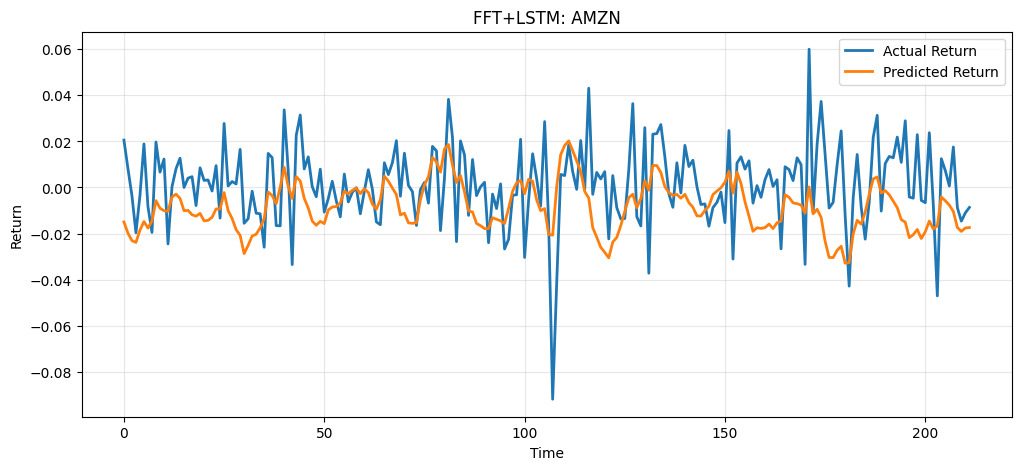

In [ ]:
# ---------------------------
# 7. Evaluation Metrics
# ---------------------------
def evaluate_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq, plot=True):
    # Dự đoán
    y_pred_train = model.predict(X_train_seq, verbose=0).squeeze()
    y_pred_test  = model.predict(X_test_seq, verbose=0).squeeze()

    # --- Metrics cho Test ---
    mse  = mean_squared_error(y_test_seq, y_pred_test)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_seq, y_pred_test)
    r2   = r2_score(y_test_seq, y_pred_test)

    # Directional Accuracy (dự đoán đúng chiều tăng/giảm)
    actual_dir = np.sign(y_test_seq[1:] - y_test_seq[:-1])   # chiều biến động thực
    pred_dir   = np.sign(y_pred_test[1:]  - y_pred_test[:-1]) # chiều biến động dự đoán
    dir_acc = (actual_dir == pred_dir).mean() if len(actual_dir) > 0 else np.nan

    # Hit Ratio theo dấu (>=0 tăng, <0 giảm)
    actual_sign = (y_test_seq >= 0).astype(int)
    pred_sign   = (y_pred_test >= 0).astype(int)
    hit_ratio   = (actual_sign == pred_sign).mean()

    # Precision, Recall, F1-Score cho phân loại tăng/giảm
    precision = precision_score(actual_sign, pred_sign)
    recall = recall_score(actual_sign, pred_sign)
    f1 = f1_score(actual_sign, pred_sign)

    # AUC-ROC và AUC-PR
    auc_roc = roc_auc_score(actual_sign, pred_sign)
    auc_pr = average_precision_score(actual_sign, pred_sign)

    # Ma trận nhầm lẫn & báo cáo phân loại dấu tăng/giảm
    cm = confusion_matrix(actual_sign, pred_sign, labels=[0, 1])  # 0: giảm, 1: tăng
    cls_report = classification_report(actual_sign, pred_sign, target_names=["Giảm", "Tăng"], digits=4)

    # In kết quả
    print("=== Evaluation Metrics ===")
    print(f"MSE      : {mse:,.6f}")
    print(f"RMSE     : {rmse:,.6f}")
    print(f"MAE      : {mae:,.6f}")
    print(f"R²       : {r2:,.6f}")
    print(f"Directional Accuracy: {dir_acc:.4f}")
    print(f"Hit Ratio (correct up/down sign): {hit_ratio:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"AUC-ROC   : {auc_roc:.4f}")
    print(f"AUC-PR    : {auc_pr:.4f}")

    print("\nConfusion Matrix (0=Decrease, 1=Increase):")
    print(cm)
    print("\nClassification Report (sign):")
    print(cls_report)

    # --- Plots ---
    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(y_test_seq, label="Actual Return", linewidth=2)
        plt.plot(y_pred_test, label="Predicted Return", linewidth=2)
        plt.title("FFT+LSTM: AMZN")
        plt.xlabel("Time")
        plt.ylabel("Return")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    # Trả về dictionary nếu bạn muốn log/so sánh
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "directional_accuracy": dir_acc,
        "hit_ratio": hit_ratio,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc_roc": auc_roc,
        "auc_pr": auc_pr,
        "confusion_matrix": cm,
        "classification_report": cls_report,
    }

# Show the evaluation metrics
evaluation_metrics = evaluate_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq)